**MATH4995 **

In [12]:

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import seaborn as sns
import PIL
import matplotlib.pyplot as plt

device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
print('Found GPU at: {}'.format(device_name))



Found GPU at: /device:GPU:0


In [13]:
def plot_metrics(history):
  plt.figure(figsize=(10,10))
  metrics =  ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch,  history.history[metric], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()
    
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

Let's load the data and do some pre-processing

In [14]:
defect_area = pd.read_csv("/kaggle/input/semi-conductor-image-classification-second-stage/defect_area.csv")


defect_area['width'] = defect_area['x_2'] - defect_area['x_1']
defect_area['height'] = defect_area['y_2'] - defect_area['y_1']

defect_area

,id,x_1,y_1,x_2,y_2,width,height
0,SOT23DUMMY01_04-APG_ITIS_H52_1_111_4,40,100,99,198,59,98
1,SOT23DUMMY01_09-APG_ITIS_H52_1_12_3,28,90,242,204,214,114
2,WEA938001D1A_17-APG_ITIS_H49_1_40_2,10,131,52,179,42,48
3,WEA938001D1A_48-APG_ITIS_H51_2_203_1,25,86,229,175,204,89
4,WEE939001B0A_14-APG_ITIS_H20_1_374_4,106,90,242,134,136,44
...,...,...,...,...,...,...,...
6691,WEP93953252A_02-APG_ITIS_H53_2_340_4,39,166,191,197,152,31
6692,WEP93955394A_44-APG_ITIS_H52_2_360_1,25,107,241,195,216,88
6693,WEP93955452A_06-APG_ITIS_H51_1_230_4,151,87,226,117,75,30
6694,WEP93955514A_57-APG_ITIS_H54_2_138_2,172,147,227,171,55,24


defect_area: (x_1, y_1) and (x_2, y_2) are the coordinates of the top left and bottom right, respectively, of the rectangle that bounds the defect area of the corresponding image id

In [15]:
import pathlib
data_dir = pathlib.Path("/kaggle/input/semi-conductor-image-classification-second-stage/train/train_contest") 
defect_dir = pathlib.Path("/kaggle/input/semi-conductor-image-classification-second-stage/train/train_contest/defect") 
good_dir = pathlib.Path("/kaggle/input/semi-conductor-image-classification-second-stage/train/train_contest/good_all") 

test_dir = pathlib.Path("/kaggle/input/semi-conductor-image-classification-second-stage/test/test_contest")  

num_defect_tr = len(list(defect_dir.glob('*.bmp')))
num_good_tr = len(list(good_dir.glob('*.bmp')))

print('total training defect images:', num_defect_tr)
print('total training good images:', num_good_tr)
print('defect : good Ratio:', num_defect_tr /num_good_tr )

total training defect images: 7039
total training good images: 27420
defect : good Ratio: 0.2567104303428155


In [16]:
batch_size = 256

IMG_HEIGHT = 192
IMG_WIDTH = 192
IMG_SHAPE = (IMG_WIDTH,IMG_HEIGHT,3)

In [17]:
from scipy import ndimage

def filter(img):
    img = ndimage.uniform_filter(img, 5)
    img[:20,:,0] = 0
    img[247:,:,0] = 0
    img[:,:20,0] = 0
    img[:,255:,0] = 0
    return img



train_image_generator = ImageDataGenerator( preprocessing_function=filter,validation_split=0.2,rescale=1./255)


train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=data_dir,
                                                           shuffle=True,                                                          
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           color_mode="grayscale",
                                                           class_mode='binary',
                                                           classes=["good_all", "defect"],
                                                           subset='training')

val_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=data_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),                                                        
                                                              class_mode='binary',
                                                              color_mode="grayscale",
                                                              classes=["good_all", "defect"],
                                                              subset='validation')

data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=data_dir,
                                                              target_size=(267, 275),                                                        
                                                              class_mode='binary',
                                                              color_mode="grayscale",
                                                              classes=["good_all", "defect"]
                                                              )

total_train = len(train_data_gen.labels)
total_val = len(val_data_gen.labels)

print("val_data_gen 1s: ", val_data_gen.labels.sum())
print("val_data_gen numb: ", len(val_data_gen.labels))

print("train_data_gen 1s: ", train_data_gen.labels.sum())
print("train_data_gen numb: ", len(train_data_gen.labels))
print("train_data_gen numb: ", val_data_gen.classes)

Found 27568 images belonging to 2 classes.
Found 6891 images belonging to 2 classes.
Found 34459 images belonging to 2 classes.
val_data_gen 1s:  1407
val_data_gen numb:  6891
train_data_gen 1s:  5632
train_data_gen numb:  27568
train_data_gen numb:  [0 0 0 ... 1 1 1]


Let's visualize the defect semi-conductor

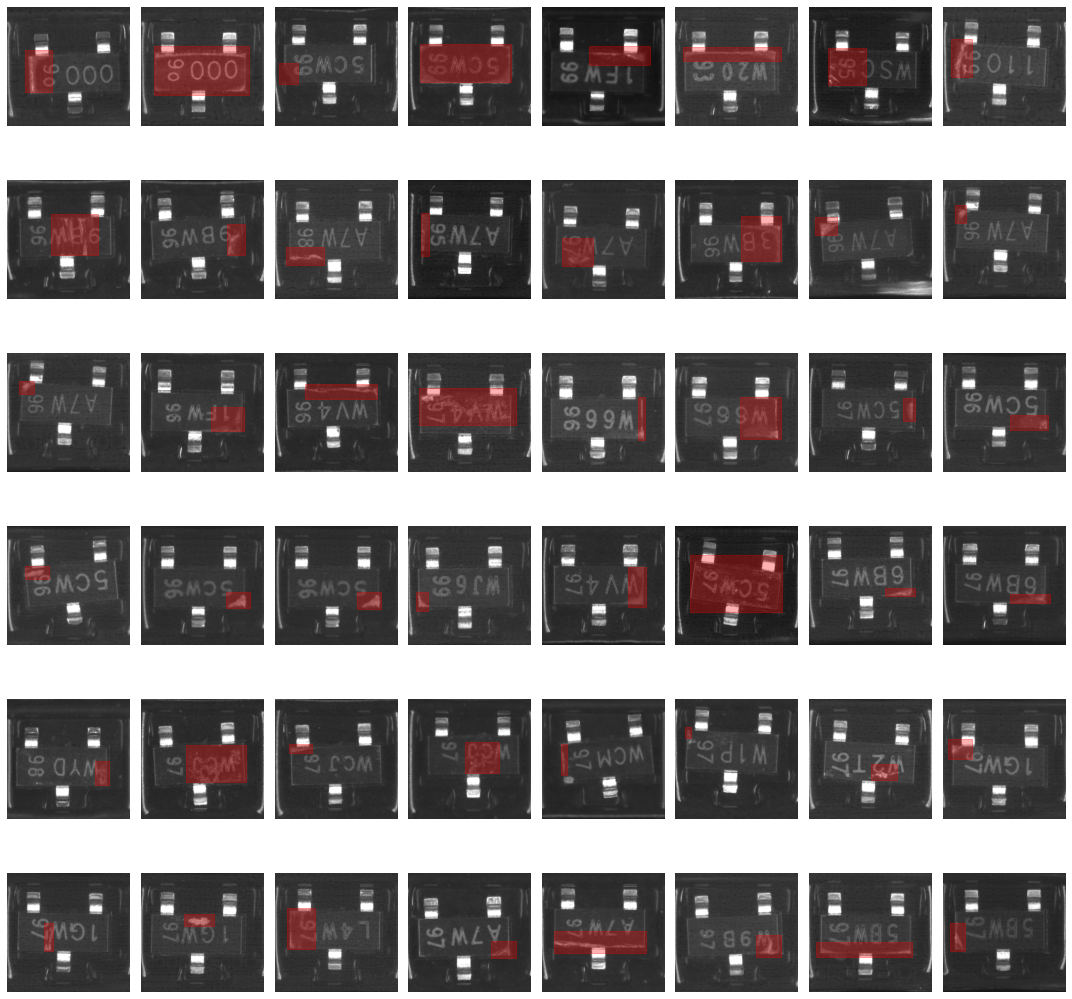

In [18]:
fig, axes = plt.subplots(6,8, figsize=(15,15))
axes = axes.flatten()
index = 0
for ax in axes:
        img = plt.imread('../input/semi-conductor-image-classification-second-stage/train/train_contest/defect/'+defect_area.loc[index]['id']+'.bmp')
        img = img.reshape(267,275,1)
        #print(type(img))
        
        img = np.concatenate((img, img,img), axis=2)
        #print(defect_area.loc[index]['x_2'])
        ax.axvspan(defect_area.loc[index]['x_1'], defect_area.loc[index]['x_2'], 
                   (275-defect_area.loc[index]['y_1'])/275 , (275-defect_area.loc[index]['y_2'])/275 , color='red', alpha=0.3)
        #print(img.shape)
        ax.imshow(img)
        ax.axis('off')
        index = index + 1

plt.tight_layout()
plt.show()

I have done the following image processing.
    1. Apply the mean filter
    2. remove the boundary (20 pixel)

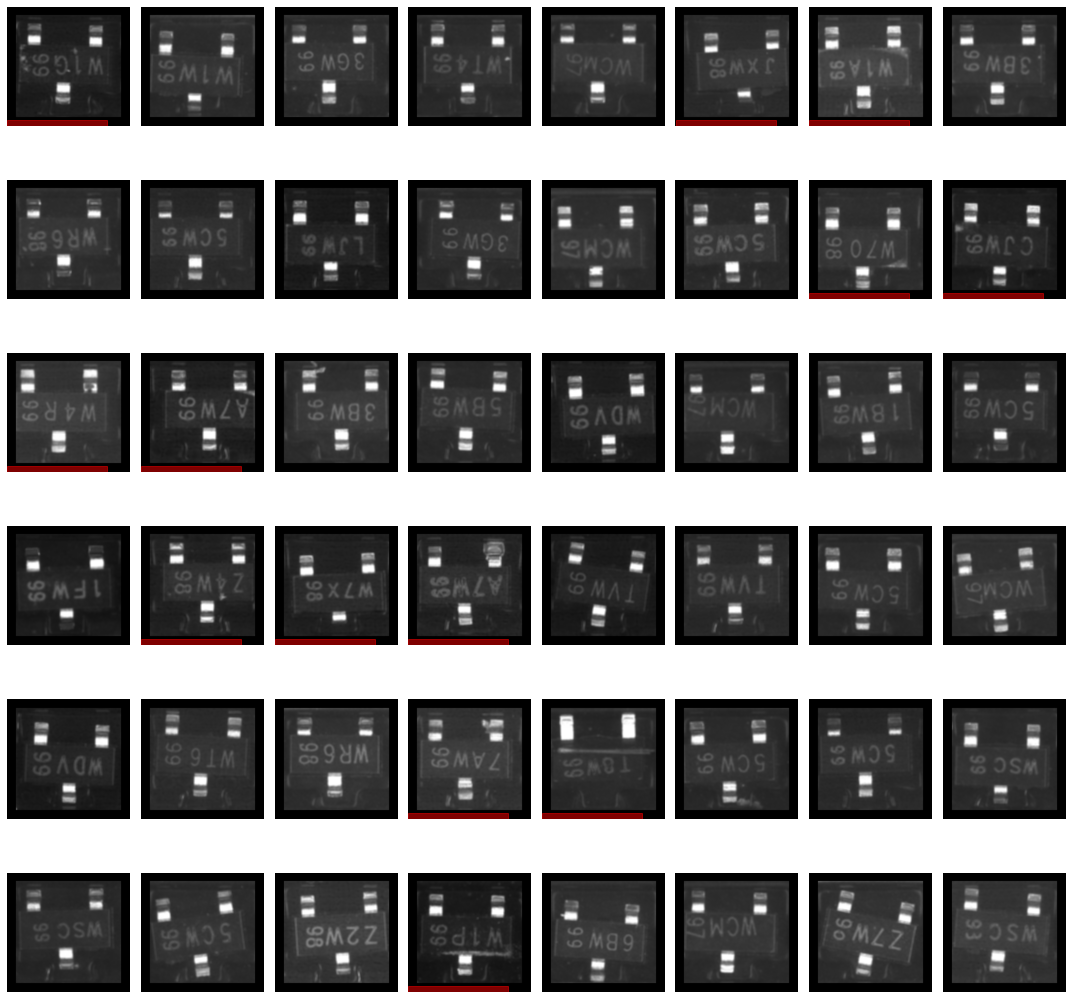

In [19]:
#print(type(defect_area))
#print(train_data_gen.filepaths[0].split("/")[-1].split(".")[0])
sample_training_images, label = next(data_gen)
#print(label.shape)
type(sample_training_images)
def plotImages(images_arr):
    index = 0
    fig, axes = plt.subplots(6, 8, figsize=(15,15))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        img = np.concatenate((img, img,img), axis=2)
        if (label[index]):
            ax.axvspan(0, 224, 0 , 0.05 , color='red', alpha=0.5)
        #print(img.shape)
        ax.imshow(img)
        ax.axis('off')
        index = index + 1
    plt.tight_layout()
    plt.show()
plotImages(sample_training_images[:48])

In [20]:
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
]

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=5,
    mode='auto',
    restore_best_weights=True)

checkpointer = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join("/kaggle/working/", "cnn2_weights.hdf5"),
    monitor="val_loss",
    verbose=1,
    save_best_only=True)

model = Sequential([
   
    Conv2D(16, 5, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,1)),
    BatchNormalization(),
    MaxPooling2D(),
    Conv2D(32, 5, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Conv2D(64, 5, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    layers.Dropout(0.3),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2=0.2)),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 192, 192, 16)      416       
_________________________________________________________________
batch_normalization_4 (Batch (None, 192, 192, 16)      64        
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 96, 96, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 96, 96, 32)        12832     
_________________________________________________________________
batch_normalization_5 (Batch (None, 96, 96, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 48, 48, 64)       

Define the model and metrics
1. Define a function that creates a simple neural network with a densly connected hidden layer, a dropout layer to reduce overfitting, and an output sigmoid layer that returns the probability of a transaction being fraudulent:

Epoch 1/50
107/107 [==============================] - ETA: 0s - loss: 3.8264 - tp: 4154.0000 - fp: 3619.0000 - tn: 18109.0000 - fn: 1430.0000 - accuracy: 0.8151 - precision: 0.5344 - recall: 0.7439 - auc: 0.8663
Epoch 00001: val_loss improved from inf to 1.30637, saving model to /kaggle/working/cnn2_weights.hdf5
107/107 [==============================] - 93s 870ms/step - loss: 3.8264 - tp: 4154.0000 - fp: 3619.0000 - tn: 18109.0000 - fn: 1430.0000 - accuracy: 0.8151 - precision: 0.5344 - recall: 0.7439 - auc: 0.8663 - val_loss: 1.3064 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5304.0000 - val_fn: 1352.0000 - val_accuracy: 0.7969 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5082
Epoch 2/50
107/107 [==============================] - ETA: 0s - loss: 1.0981 - tp: 4027.0000 - fp: 1289.0000 - tn: 20449.0000 - fn: 1547.0000 - accuracy: 0.8962 - precision: 0.7575 - recall: 0.7225 - auc: 0.9222
Epoch 00002: val_loss did not improve from 1.30637
107/107 [===========

107/107 [==============================] - ETA: 0s - loss: 0.5228 - tp: 4838.0000 - fp: 300.0000 - tn: 21427.0000 - fn: 747.0000 - accuracy: 0.9617 - precision: 0.9416 - recall: 0.8662 - auc: 0.9853
Epoch 00013: val_loss improved from 1.20408 to 0.68593, saving model to /kaggle/working/cnn2_weights.hdf5
107/107 [==============================] - 92s 861ms/step - loss: 0.5228 - tp: 4838.0000 - fp: 300.0000 - tn: 21427.0000 - fn: 747.0000 - accuracy: 0.9617 - precision: 0.9416 - recall: 0.8662 - auc: 0.9853 - val_loss: 0.6859 - val_tp: 943.0000 - val_fp: 135.0000 - val_tn: 5158.0000 - val_fn: 420.0000 - val_accuracy: 0.9166 - val_precision: 0.8748 - val_recall: 0.6919 - val_auc: 0.9026
Epoch 14/50
107/107 [==============================] - ETA: 0s - loss: 0.5672 - tp: 4889.0000 - fp: 324.0000 - tn: 21404.0000 - fn: 695.0000 - accuracy: 0.9627 - precision: 0.9378 - recall: 0.8755 - auc: 0.9868
Epoch 00014: val_loss did not improve from 0.68593
107/107 [==============================] - 94

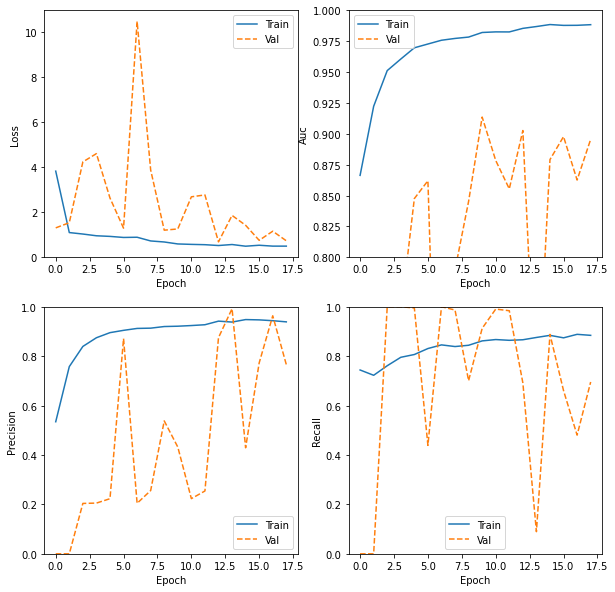

In [21]:
epochs = 50
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)
history = model.fit(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    callbacks=[early_stopping, checkpointer],
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

model.save("my_model")

model.evaluate(val_data_gen)


plot_metrics(history)

test_image_generator = ImageDataGenerator(preprocessing_function=filter, rescale=1./255)

test_data_gen = test_image_generator.flow_from_directory(directory=test_dir,
                                                              class_mode=None,
                                                              shuffle=False,
                                                              color_mode="grayscale",
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              )
test_data_gen.filepaths

result = model.predict(test_data_gen).flatten()
result

output = pd.DataFrame(columns=['id', 'defect_score'])

index = 0
for child in test_dir.glob('test/*'):
    output = output.append({'id': test_data_gen.filepaths[index].split("/")[-1].split(".")[0] , 'defect_score' : result[index] }, ignore_index=True)
    index = index + 1

output

output.to_csv('/kaggle/working/submission.csv', index=False)

27/27 [==============================] - 17s 648ms/step - loss: 0.6841 - tp: 978.0000 - fp: 140.0000 - tn: 5344.0000 - fn: 429.0000 - accuracy: 0.9174 - precision: 0.8748 - recall: 0.6951 - auc: 0.9036
loss :  0.6841353178024292
tp :  978.0
fp :  140.0
tn :  5344.0
fn :  429.0
accuracy :  0.9174285531044006
precision :  0.8747763633728027
recall :  0.695095956325531
auc :  0.9035826921463013

Legitimate Transactions Detected (True Negatives):  4580
Legitimate Transactions Incorrectly Detected (False Positives):  904
Fraudulent Transactions Missed (False Negatives):  1193
Fraudulent Transactions Detected (True Positives):  214
Total Fraudulent Transactions:  1407


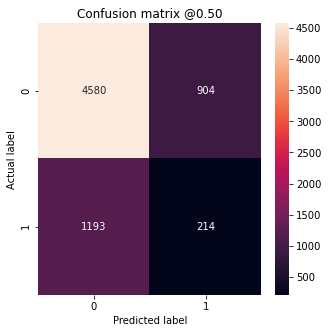

In [22]:
baseline_results = model.evaluate(val_data_gen )
val_predictions_baseline = model.predict(val_data_gen )
train_predictions_baseline = model.predict(train_data_gen )
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(val_data_gen.classes, val_predictions_baseline )

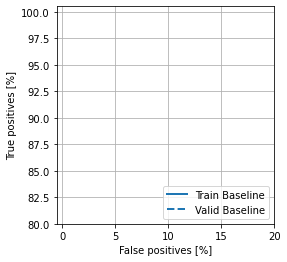

In [26]:
import sklearn
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plot_roc("Train Baseline", train_data_gen.classes, train_predictions_baseline, color=colors[0])
plot_roc("Valid Baseline", val_data_gen.classes, val_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')